# [AMLD'19 Learning and Processing over Networks](https://github.com/rodrigo-pena/amld2019-graph-workshop)

# 4 Spectral representation and filtering

In this notebook, we'll explore the spectral representation of signals and how we use filters to alter it.
We'll use the [PyGSP], a Python package that eases Signal Processing on Graphs.

[pygsp]: https://github.com/epfl-lts2/pygsp

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pygsp as pg

In [ ]:
#plt.rcParams['figure.figsize'] = (17, 5)

## 4.1 Point cloud denoising

The goal of this section is to get familiar with two representations of a signal:
* its representation in the vertex domain
* its representation in the spectral domain

1. Load the [Stanford bunny](https://en.wikipedia.org/wiki/Stanford_bunny) point cloud.
   It is available in the PyGSP as `pg.graphs.Bunny()`.
2. Plot the point cloud.
   You can plot a PyGSP graph with `my_graph.plot()`.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x124078ba8>)

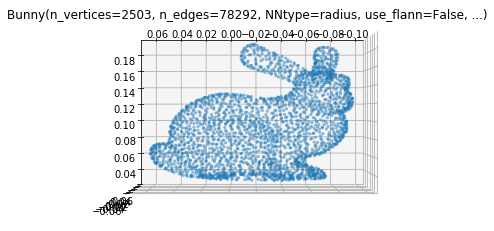

In [71]:
graph =  pg.graphs.Bunny()  # Your code here.
graph.plot()

The position of each point along the x axis can be viewed as a signal on the bunny graph.
As such, we can compute its Fourier transform and look at it in the spectral domain.

1. Compute the spectral representation of the signal.
   The coordinate signal can be accessed at `graph.coords`.
   The Fourier transform is computed with `my_graph.gft(my_signal)`.
1. Plot it as a function of the eigenvalues (found as the property `my_graph.e`).
1. Is the signal energy concentrated in the low or high frequencies?
1. What does that mean?

In [72]:
# Your code here.
my_signal = graph.coords
my_gft = graph.gft(my_signal)

2019-01-26 16:11:38,009:[WARNING](pygsp.graphs.graph._check_fourier_properties): The Fourier basis G.U is not available, we need to compute the Fourier basis. Explicitly call G.compute_fourier_basis() once beforehand to suppress the warning.


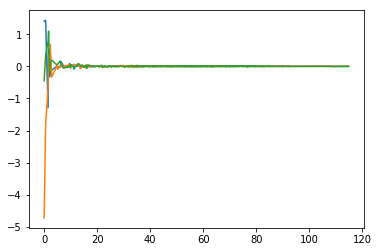

In [63]:
plt.plot(graph.e, my_gft)

Add some noise, e.g. with `np.random.normal()` (a reasonable scale is `4e-3`), to the 3D position of the vertices (stored in `graph.coords`).

In [74]:
noisy_graph = graph

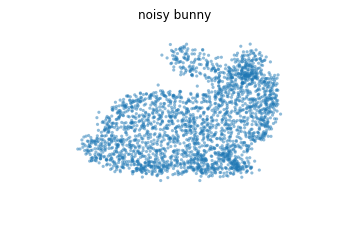

In [73]:
noise = np.random.normal(scale=4e-3, size=np.shape(graph.coords)) # Your code here.

coords_clean = graph.coords
coords_noisy = graph.coords + noise
noisy_graph.coords = coords_noisy

fig, ax = noisy_graph.plot(title='noisy bunny')
ax.axis('off');

Look again at the frequency content of the position signal.
What changed?

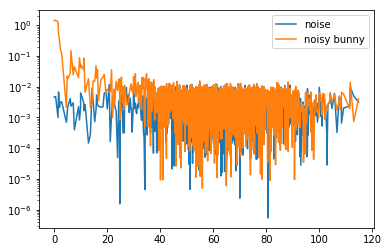

In [75]:
plt.semilogy(graph.e, abs(graph.gft(noise[:, 0])), label='noise');
plt.semilogy(graph.e, abs(graph.gft(graph.coords[:, 0])), label='noisy bunny');
plt.legend();

To denoise, we have to remove the noise while keeping the information, which is the shape of the bunny.
Visually, you should see that it is much easier to do that in the spectral domain than in the spatial domain!

Design a filter that will remove the high frequencies, where the noise is concentrated, while keeping the low frequencies, where the information is concentrated.
Try the following filters: `pg.filters.Heat`, `pg.filters.Rectangular`, and `pg.filters.Expwin`. Do play with their parameters!
You can plot a filter's response with `my_filter.plot()`.

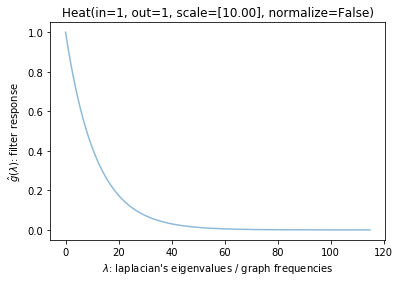

In [76]:
# Your code here.
my_filter = pg.filters.Heat(graph)
my_filter.plot(eigenvalues=False);

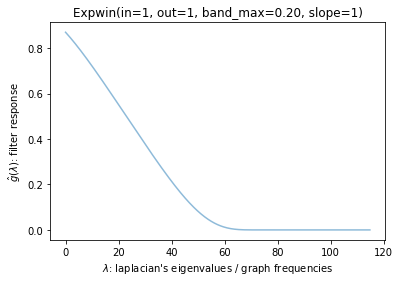

In [87]:
# Your code here.
my_filter = pg.filters.Expwin(graph)
my_filter.plot(eigenvalues=False);

1. Filter the noisy coordinates with the filter you just designed.
   Use `my_filter.filter(my_signal)`.
   If using a rectangular filter, additionally set the option method='exact'.
1. Look at the frequency content before and after filtering.
   Do you see the effect of the filter?

In [88]:
denoised_graph = noisy_graph

In [89]:
denoised_graph.coords = my_filter.filter(noisy_graph.coords) # Your code here.

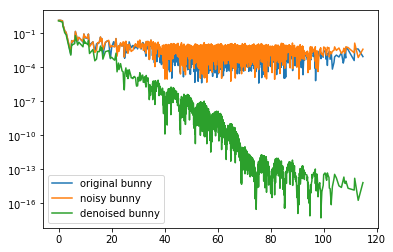

In [90]:
plt.semilogy(graph.e, abs(graph.gft(coords_clean[:, 0])), label='original bunny');
plt.semilogy(graph.e, abs(graph.gft(coords_noisy[:, 0])), label='noisy bunny');
plt.semilogy(denoised_graph.e, abs(graph.gft(denoised_graph.coords[:, 0])), label='denoised bunny');
plt.legend();

Finally, look at the denoised bunny in the spatial domain.

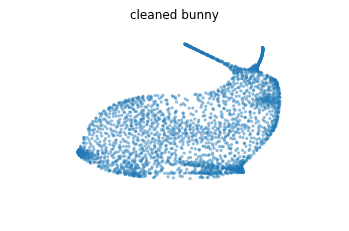

In [91]:
fig, ax = graph.plot(title='cleaned bunny')
ax.axis('off');

## 4.2 Heat diffusion

The goal of this section is to see how we can use filters to solve the [heat equation](https://en.wikipedia.org/wiki/Heat_equation).

Define a domain on which we'll diffuse heat.
You can try the following graphs: `Sensor`, `Airfoil`, `Comet`.

In [118]:
graph = pg.graphs.Sensor() # Your code here.

Define an initial heat distribution.
A good one to try first to get some intuition is a delta: i.e., a signal that has value 1 on a vertex (or multiple vertices) and 0 everywhere else.
Plot that signal on the graph with `my_graph.plot(my_signal)`.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13794e5c0>)

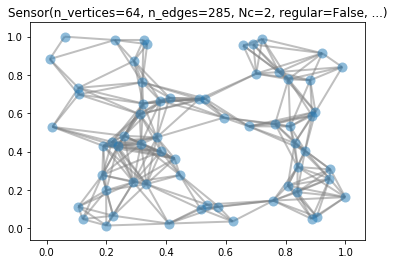

In [119]:
graph.plot()

2019-01-26 16:26:10,325:[WARNING](pygsp.graphs.graph._check_fourier_properties): The Fourier basis G.U is not available, we need to compute the Fourier basis. Explicitly call G.compute_fourier_basis() once beforehand to suppress the warning.


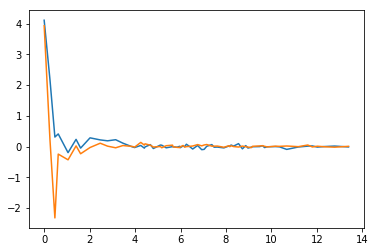

In [120]:
# Your code here.
my_signal = graph.coords
my_gft = graph.gft(my_signal)
plt.plot(graph.e, my_gft)

Instantiate a [heat kernel](https://en.wikipedia.org/wiki/Heat_kernel) with `pg.filters.Heat`. Plot its frequency response.

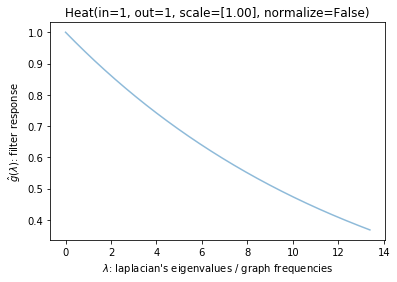

In [127]:
heat = pg.filters.Heat(graph, scale=1.0) # Your code here.
heat.plot(eigenvalues=False);

Filter your initial distribution with the heat kernel and observe how heat diffuses.
Note that the `scale` parameter of the kernel controls the amount of diffusion.
What is the solution after infinite time?

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x128446ac8>)

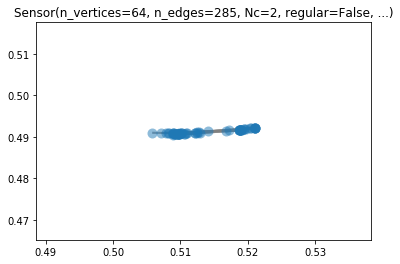

In [128]:
# Your code here.
filtered_graph = graph
filtered_graph.coords = heat.filter(graph.coords) 
filtered_graph.plot()

## 4.3 Curvature estimation

Filters can not only be used to alter signals and solve PDEs, but also to extract information from the graph. In this section, we'll use a set of [wavelet](https://en.wikipedia.org/wiki/Wavelet) filters to estimate the curvature of a surface.

In [187]:
graph = pg.graphs.Bunny()
graph.estimate_lmax()

Create a filterbank of 6 mexican hat wavelets.
Visualize the filterbank in the spectral domain.

In [137]:
# Your code here.
mexicanhat_filter = pg.filters.MexicanHat(graph, 6)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1290ad5f8>)

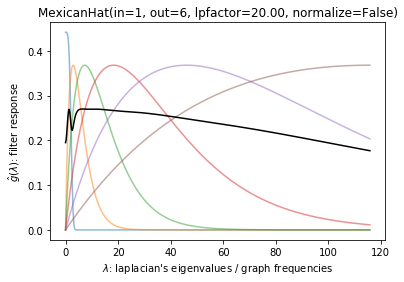

In [138]:
mexicanhat_filter.plot(eigenvalues=False)

Visualize the filterbank in the vertex domain.
Look at some of the localized wavelets.
You can localize a filter with `my_filter.localize()`.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1289f5668>)

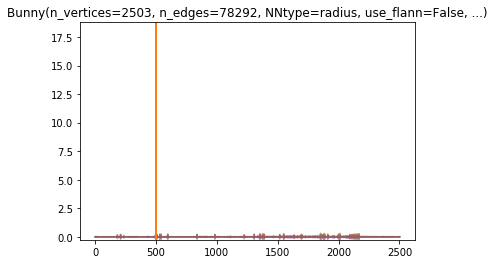

In [179]:
DELTA = 500
graph.set_coordinates('line1D')
# Your code here.
s = mexicanhat_filter.localize(DELTA)
graph.plot_signal(s, highlight=DELTA)

Let's now try to estimate the curvature of the underlying 3D model by only using spectral filtering on the nearest-neighbor graph formed by its point cloud.
A simple, but not theoretically grounded, way to accomplish that is to use the coordinates map $[x, y, z]$ and filter it using the above defined wavelets.
Doing so gives us a set of $N_f$ 3-dimensional signals $[g_i(L)x, g_i(L)y, g_i(L)z], \ i \in [0, \ldots, N_f]$ that describe variation along the 3 coordinates.

In [190]:
# Your code here.
s = graph.coords
s = mexicanhat_filter.filter(s)

The curvature is then estimated by taking the $\ell_1$ or $\ell_2$ norm across the 3D position.

In [192]:
# Your code here.
s = np.linalg.norm(s, ord=2, axis=1)

Plot the result to observe that we indeed have a measure of the curvature at different scales.

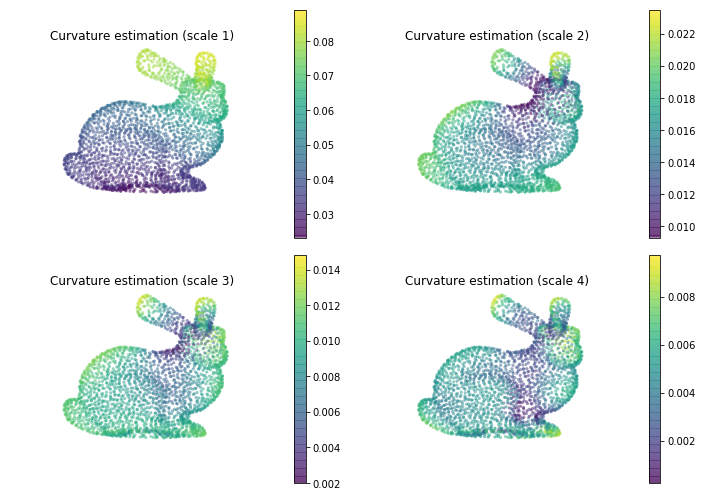

In [193]:
# Your code here.
fig = plt.figure(figsize=(10, 7))
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    graph.plot_signal(s[:, i], ax=ax)
    title = 'Curvature estimation (scale {})'.format(i+1)
    _ = ax.set_title(title)
    ax.set_axis_off()
fig.tight_layout()